In [1]:
from dotenv import load_dotenv
load_dotenv()

True

Define tool functions that we can use in our graph.

In [2]:
from langchain_core.tools import tool

# Tools

@tool
def get_projects():
    """
    Returns a list of mock time entry projects for a software consulting company.
    Each project includes client name, project name, and project ID.
    """
    return [
        {
            "client_name": "Acme Corporation",
            "project_name": "E-commerce Platform Redesign",
            "project_id": "aef12d88-e0ae-4949-b7a2-7704f3b0c1d0"
        },
        {
            "client_name": "TechNova Inc.",
            "project_name": "Mobile App Development",
            "project_id": "b57cf8e2-3714-4b83-9d63-afcd23e0f87b"
        },
        {
            "client_name": "Global Finance Group",
            "project_name": "Payment Processing System",
            "project_id": "c982b427-59a5-4c5e-b3f6-76ae4c1d9e5d"
        },
        {
            "client_name": "HealthCare Solutions",
            "project_name": "Patient Management Portal",
            "project_id": "d341f57a-6890-4f13-a8de-92c23481b6c2"
        },
        {
            "client_name": "EduTech Ventures",
            "project_name": "Learning Management System",
            "project_id": "e725d1b9-4a07-41b8-9c15-3f7b60c84a36"
        },
        {
            "client_name": "Intertech",
            "project_name": "Paid Time Off",
            "project_id": "f109e384-5c27-49f5-b651-48e72a0dca7f"
        }
    ]

@tool
def book_time_entry(clientName: str, projectName: str, projectId: str, date: str, hours: int):
    """
    Books a time entry for a given project.

    Args:
        clientName (str): The name of the client.
        projectName (str): The name of the project.
        projectId (str): The unique identifier for the project.
        date (str): The date for the time entry in ISO format (YYYY-MM-DD).
        hours (int): The number of hours to book.
    """
    return "Time entry was created successfully."


tools = [get_projects, book_time_entry]

In [3]:
from langchain_anthropic import ChatAnthropic

# Language Model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219").bind_tools(tools)

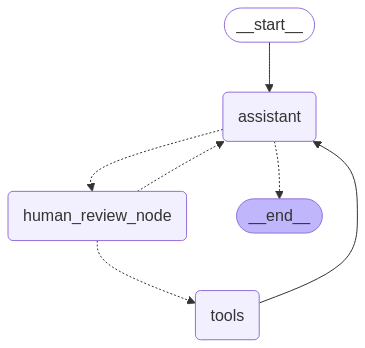

In [ ]:
from datetime import date
from IPython.display import Image, display
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from typing_extensions import TypedDict, Literal

@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"

# System message
sys_msg = SystemMessage(content=f"""
    You are a helpful assistant tasked with helping Intertech employees track time spent on projects.
    Today is {date.today().isoformat()}.
    """)

model = ChatAnthropic(model_name="claude-3-5-sonnet-latest").bind_tools(
    [get_projects, book_time_entry]
)


class State(MessagesState):
    """Simple state."""


def assistant(state: MessagesState):
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


def human_review_node(state) -> Command[Literal["assistant", "tools"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    if tool_call["name"] == "get_projects":
        # If the tool call is for get_projects, we don't need to ask for human review
        return Command(goto="tools")

    args = tool_call["args"]

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": f"""
            Client: {args['clientName']}
            Project: {args['projectName']}
            Date: {args['date']}
            Hours: {args['hours']}
            Continue?
            """,
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="tools")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="tools", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="assistant", update={"messages": [tool_message]})



def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(assistant)
builder.add_node(ToolNode([get_projects, book_time_entry]))
builder.add_node(human_review_node)
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", route_after_llm)
builder.add_edge("tools", "assistant")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": [{"role": "user", "content": "I worked on Acme for 5 hours yesterday"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'assistant': {'messages': [AIMessage(content=[{'text': "I'll help you book a time entry for the Acme project from yesterday. Let me first check the project details to get the required information.", 'type': 'text'}, {'id': 'toolu_016LavNHgufpeWbKsLYtVyy3', 'input': {}, 'name': 'get_projects', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RnrcKGEXbTFmhFQJibuXpL', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 592, 'output_tokens': 67}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-387d9474-12bc-46d4-9120-e0d62f18f391-0', tool_calls=[{'name': 'get_projects', 'args': {}, 'id': 'toolu_016LavNHgufpeWbKsLYtVyy3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 592, 'output_tokens': 67, 'total_tokens': 659, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}}


{'human_review_node': None}


{'tools': {'me

In [6]:
state = graph.get_state(thread)
print(state.values["messages"][-1].pretty_print())
print("\nNext Node:")
print(state.next)


================================== Ai Message ==================================

[{'text': "I've found the Acme Corporation project details. Let me book your time entry for yesterday.", 'type': 'text'}, {'id': 'toolu_011syGPK4bs1KsEfzx6WQ8t5', 'input': {'clientName': 'Acme Corporation', 'projectName': 'E-commerce Platform Redesign', 'projectId': 'aef12d88-e0ae-4949-b7a2-7704f3b0c1d0', 'date': '2024-01-09', 'hours': 5}, 'name': 'book_time_entry', 'type': 'tool_use'}]
Tool Calls:
  book_time_entry (toolu_011syGPK4bs1KsEfzx6WQ8t5)
 Call ID: toolu_011syGPK4bs1KsEfzx6WQ8t5
  Args:
    clientName: Acme Corporation
    projectName: E-commerce Platform Redesign
    projectId: aef12d88-e0ae-4949-b7a2-7704f3b0c1d0
    date: 2024-01-09
    hours: 5
None

Next Node:
('human_review_node',)


In [7]:
for event in graph.stream(
    # provide value
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': None}


{'tools': {'messages': [ToolMessage(content='Time entry was created successfully.', name='book_time_entry', id='20fd7113-8bd8-4783-bf9b-3f6519d38b13', tool_call_id='toolu_011syGPK4bs1KsEfzx6WQ8t5')]}}


{'assistant': {'messages': [AIMessage(content="I've booked 5 hours for yesterday on the Acme Corporation E-commerce Platform Redesign project. The time entry has been created successfully. Is there anything else you need help with?", additional_kwargs={}, response_metadata={'id': 'msg_01WQ6KigHqtC3cwkjLbFA1Hg', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1217, 'output_tokens': 46}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-358373de-f2c0-46ce-93cb-6e43a86be372-0', usage_metadata={'input_tokens': 1217, 'output_tokens': 46, 'total_tokens': 1263, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}}


